# Setup

In [63]:
import pandas as pd
import numpy as np
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

In [64]:
stock_data = pd.read_csv("Datasets/final_set.csv")

data = []

for i in stock_data.values:
    if i[8] == "Residential" and i[5] == "British Columbia":
        data.append(i)
df = pd.DataFrame(data)
df.columns = [
    "Municipality",
    "Latitude",
    "Longitude",
    "CGNDB ID",
    "Generic Term",
    "Province - Territory",
    "Nearest NSRDB latitude",
    "Nearest NSRDB longitude",
    "Array Type",
    "Market Pricing",
    "Tariff Applied",
    "First Yr Annual (MWh)",
    "First Yr Winter (MWh)",
    "First Yr Spring (MWh)",
    "First Yr Summer (MWh)",
    "First Yr Fall (MWh)",
    "Installation Cost Scenario",
    "Breakeven Price ($/MWh)",
    "Reference Price ($/MWh)",
    "Breakeven Price (¢/kWh)",
    "Reference Price (¢/kWh)",
    "Total Capacity (MW)",
    "Annual",
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]




# K is 20; 33/66 Train/Eval

In [ ]:
df = df.sort_index()

In [ ]:
df_train = df.iloc[0: math.floor(df.shape[0] / 3)]
df_eval = df.iloc[(math.floor(df.shape[0] / 3)): df.shape[0]]

In [ ]:
feats_train = df_train[["Latitude", "Longitude",
                        "Total Capacity (MW)", "Annual"]]
trainfeatlist = [list(row) for row in feats_train.values]
labels_train = df_train[["First Yr Annual (MWh)"]]
trainlabellist = [list(row) for row in labels_train.values]


feats_eval = df_eval[["Latitude", "Longitude",
                      "Total Capacity (MW)", "Annual"]]
evalfeatlist = [list(row) for row in feats_eval.values]
labels_eval = df_eval[["First Yr Annual (MWh)"]]
evallabellist = [list(row) for row in labels_eval.values]


In [ ]:
model = KNeighborsRegressor()
knn_grid = {"n_neighbors": np.arange(1, 20)}
model_knn = GridSearchCV(model, knn_grid, cv=10)
model_knn.fit(trainfeatlist, trainlabellist)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Training: ", model_knn.best_score_, "\n")



In [ ]:
print(pd.DataFrame(model_knn.cv_results_))

In [ ]:
output = model_knn.predict(evalfeatlist)
print("R^2 - Evaluation: ", model_knn.score(evalfeatlist, evallabellist))


In [ ]:
print(mean_absolute_error(evallabellist, output))


# BC Split in Half by Latitude

In [ ]:
df = df.sort_values(by=["Latitude"])
#df_a = df.sort_values(by=["Latitude"])


In [ ]:
print(df)

In [ ]:
df_train = df.iloc[0: math.floor(df.shape[0]/2)]
print(df)
df_eval = df.iloc[math.floor(df.shape[0]/2): df.shape[0]]


In [ ]:
print(df_eval)

In [ ]:
print(df_train)

In [ ]:
feats_train = df_train[["Latitude", "Longitude",
                        "Total Capacity (MW)", "Annual"]]
trainfeatlist = [list(row) for row in feats_train.values]
labels_train = df_train[["First Yr Annual (MWh)"]]
trainlabellist = [list(row) for row in labels_train.values]


feats_eval = df_eval[["Latitude", "Longitude",
                      "Total Capacity (MW)", "Annual"]]
evalfeatlist = [list(row) for row in feats_eval.values]
labels_eval = df_eval[["First Yr Annual (MWh)"]]
evallabellist = [list(row) for row in labels_eval.values]


In [ ]:
model = KNeighborsRegressor()
knn_grid = {"n_neighbors": np.arange(1, 20)}
model_knn = GridSearchCV(model, knn_grid, cv=10)
model_knn.fit(trainfeatlist, trainlabellist)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Training: ", model_knn.best_score_, "\n")


In [ ]:
print(pd.DataFrame(model_knn.cv_results_))


In [ ]:
output = model_knn.predict(evalfeatlist)
print("R^2 - Evaluation: ", model_knn.score(evalfeatlist, evallabellist))


In [ ]:
print(mean_absolute_error(evallabellist, output))


# BC Split in Half by Longitude

In [ ]:
df = df.sort_values(by=["Longitude"])


In [ ]:
print(df)


In [ ]:
df_train = df.iloc[0: math.floor(df.shape[0]/2)]
df_eval = df.iloc[math.floor(df.shape[0]/2): df.shape[0]]


In [ ]:
print(df_train)

In [ ]:
print(df_eval)

In [ ]:
feats_train = df_train[["Latitude", "Longitude",
                        "Total Capacity (MW)", "Annual"]]
trainfeatlist = [list(row) for row in feats_train.values]
labels_train = df_train[["First Yr Annual (MWh)"]]
trainlabellist = [list(row) for row in labels_train.values]


feats_eval = df_eval[["Latitude", "Longitude",
                      "Total Capacity (MW)", "Annual"]]
evalfeatlist = [list(row) for row in feats_eval.values]
labels_eval = df_eval[["First Yr Annual (MWh)"]]
evallabellist = [list(row) for row in labels_eval.values]


In [ ]:
model = KNeighborsRegressor()
knn_grid = {"n_neighbors": np.arange(1, 20)}
model_knn = GridSearchCV(model, knn_grid, cv=10)
model_knn.fit(trainfeatlist, trainlabellist)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Training: ", model_knn.best_score_, "\n")


In [ ]:
print(pd.DataFrame(model_knn.cv_results_))


In [ ]:
output = model_knn.predict(evalfeatlist)
print("R^2 - Evaluation: ", model_knn.score(evalfeatlist, evallabellist))


In [ ]:
print(mean_absolute_error(evallabellist, output))


# Mapping Points in BC

<AxesSubplot:title={'center':'British Columbia'}, xlabel='Longitude', ylabel='Latitude'>

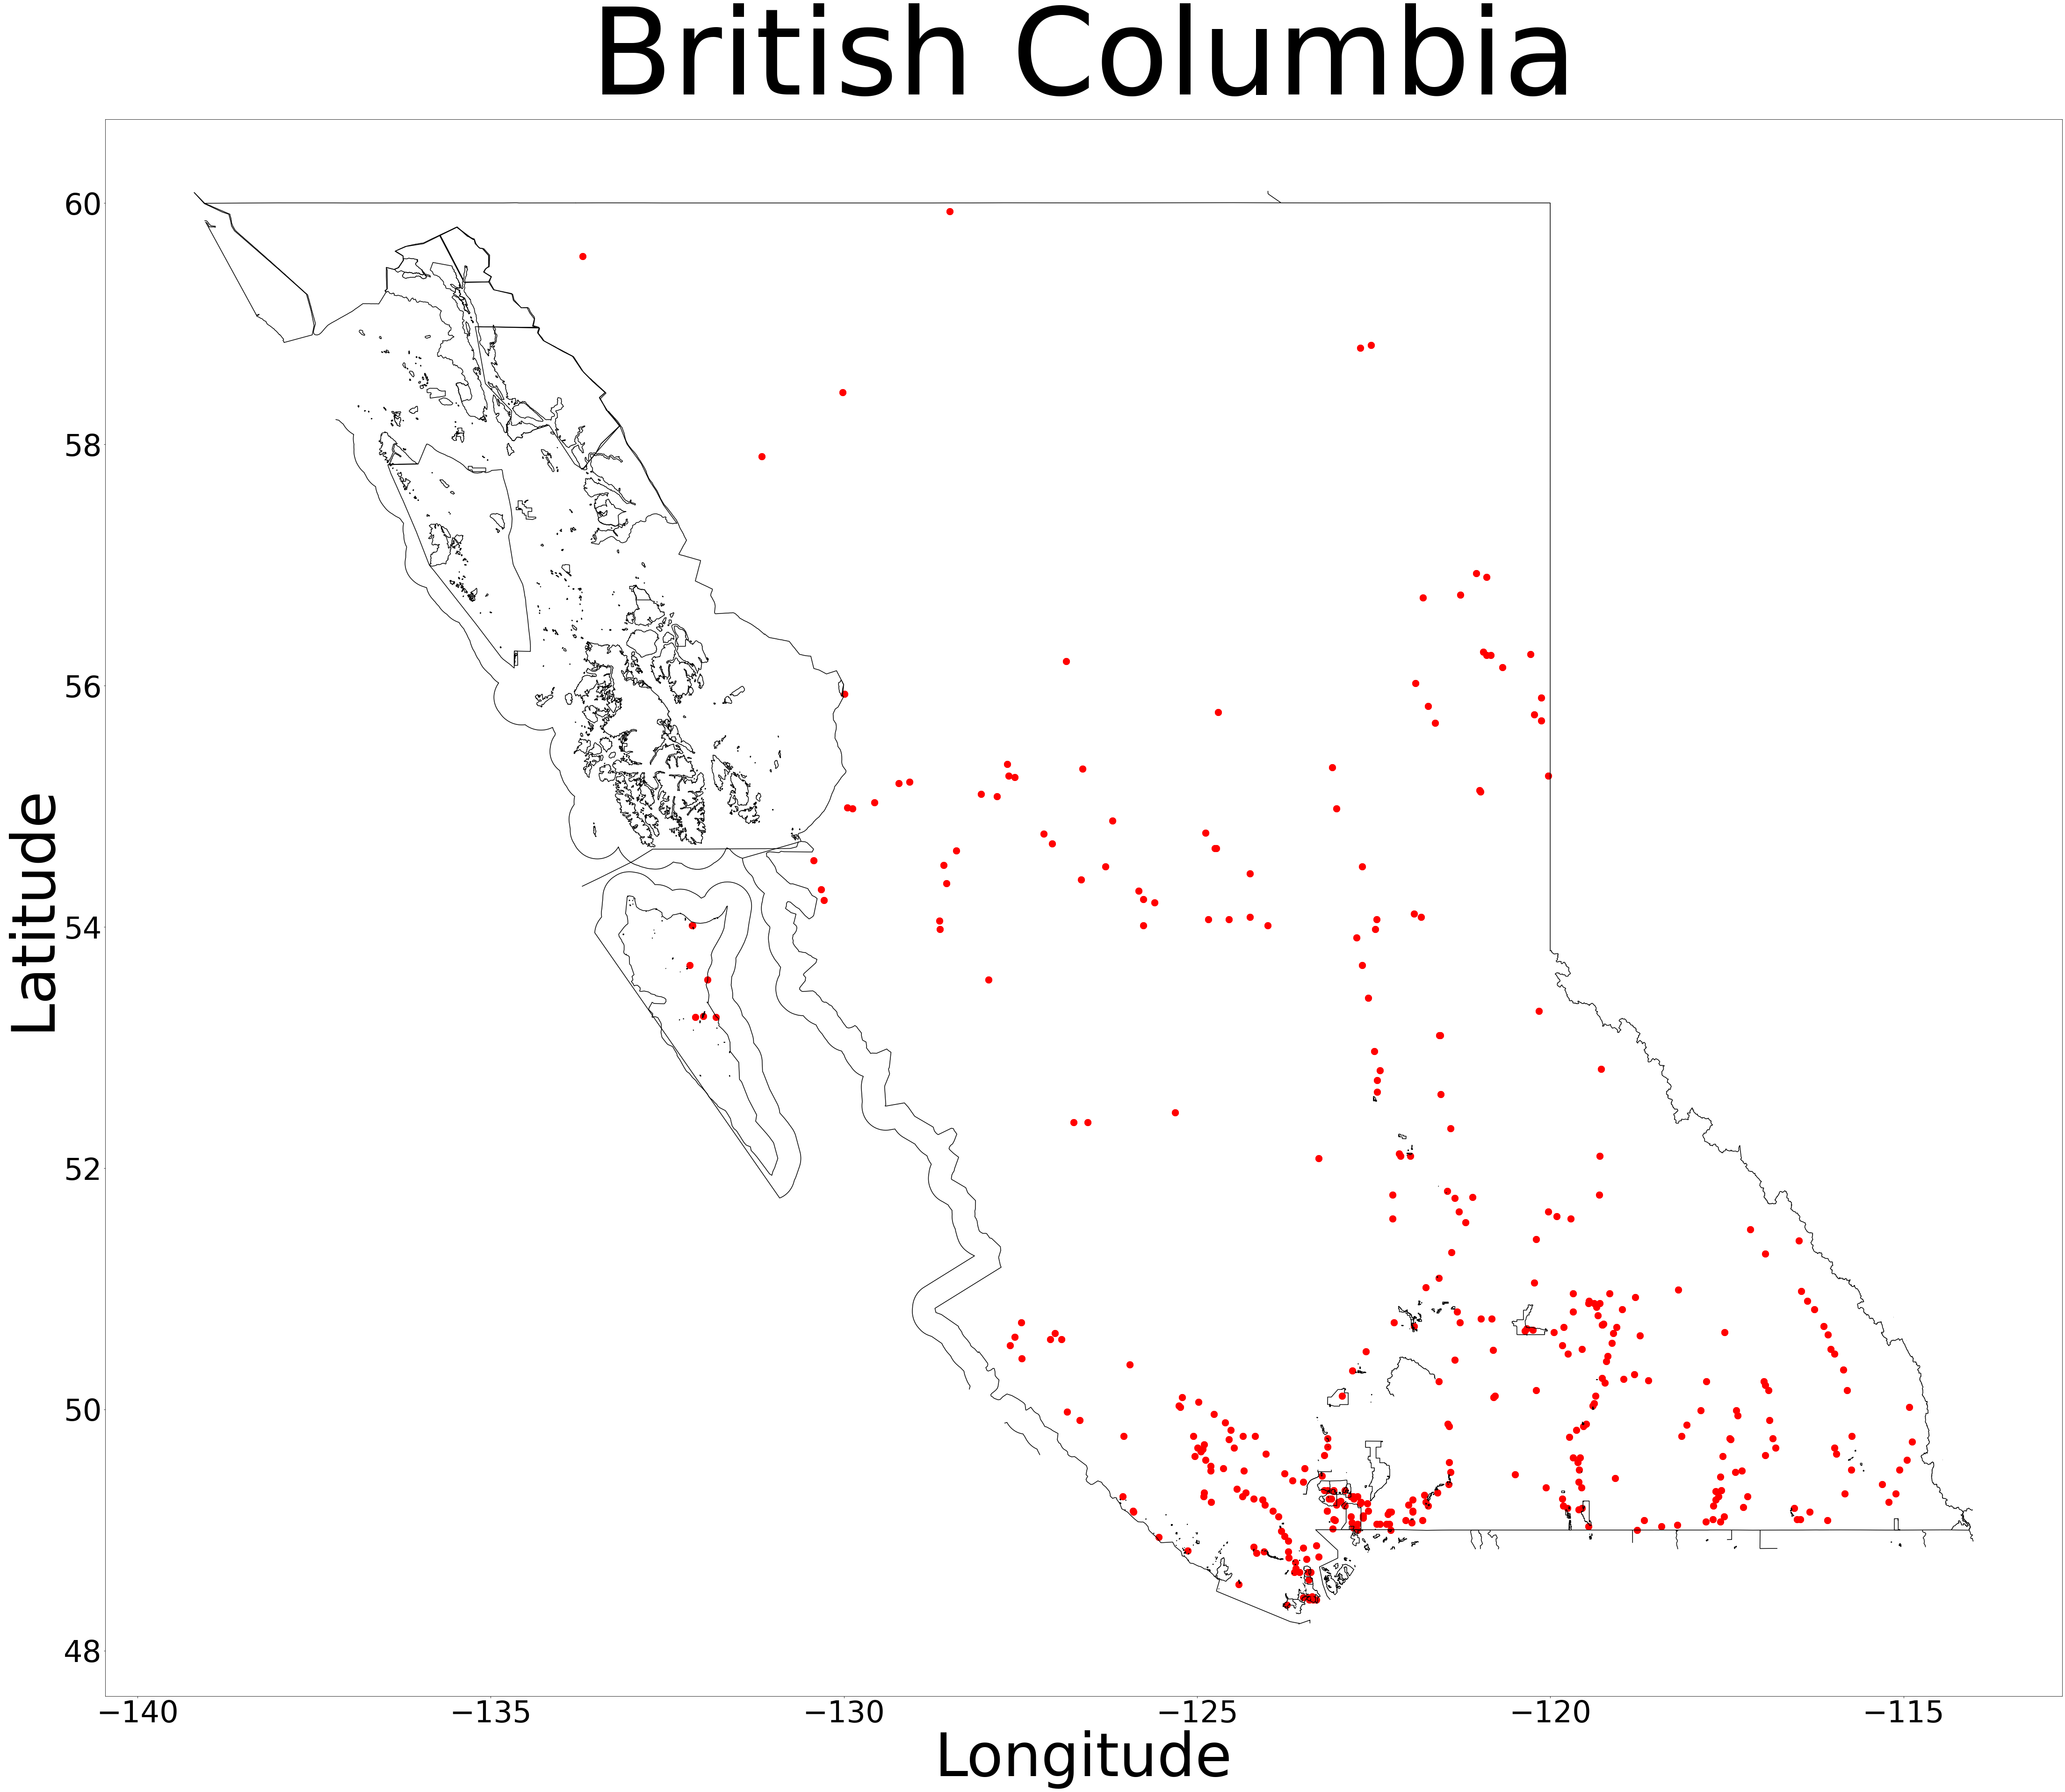

In [65]:
map = gpd.read_file("Shapefile/british_columbia_administrative.shp")
fig, ax = plt.subplots(figsize=(75, 75))
crs = CRS("EPSG:4326")

df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)
points = df[["Latitude", "Longitude"]]
geometry = [Point(xy) for xy in (zip(df["Longitude"], df["Latitude"]))]
geoframe = gpd.GeoDataFrame(points, crs=crs, geometry=geometry)

graph = map.plot(ax=ax, alpha=1, color="black")
graph.set_title("British Columbia", size=256)
plt.xlabel("Longitude", fontsize=128)
plt.ylabel("Latitude", fontsize=128)
plt.xticks(fontsize=64)
plt.yticks(fontsize=64)

geoframe.plot(ax=ax, color="red", markersize=200)

